In [57]:
import numpy as np
import pandas as pd
import pickle
import itertools
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import xgboost as xgb


In [4]:
RANDOM_STATE = 888

In [5]:
ANSWER_TEST_PATH = 'answers_test.csv'
users_data_df_PATH = 'data_test.csv'
DATA_TRAIN_FEATURES_PATH = 'data_train_features.csv'
DATA_TEST_FEATURES_PATH = 'data_test_features.csv'

### Получаем данные

In [6]:
data_train  = pd.read_csv(DATA_TRAIN_FEATURES_PATH)

data_train.head()

,id,vas_id,target,0,1,2,3,4,5,6,...,246,247,248,249,250,251,252,week_on_month,day,month
0,2814496,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,9,7
1,212196,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,9,7
2,3929509,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,9,7
3,2379697,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,9,7
4,415308,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,9,7


In [8]:
# Разделим признаки и целевую переменную
data_prelim = data_train.copy()

X = data_prelim.drop('target', axis=1)
y = data_prelim['target']

In [9]:
X.loc[(X['252'] > 1, '252')] = 2.0
X.head()

,id,vas_id,0,1,2,3,4,5,6,7,...,246,247,248,249,250,251,252,week_on_month,day,month
0,2814496,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,9,7
1,212196,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,9,7
2,3929509,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,9,7
3,2379697,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,9,7
4,415308,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,9,7


In [10]:
print("ID уникален? ", X.index.is_unique)
print("Есть ли дубли в строках?", X.duplicated().sum())
print("Сколько процент признаков могут принимать null-значениями? %d%%" % float((X.isnull().sum() > 0).sum()/X.shape[1]*100))

ID уникален?  True
Есть ли дубли в строках? 0
Сколько процент признаков могут принимать null-значениями? 98%


### Определяем типы переменных

In [18]:
X_nunique = X.apply(lambda x: x.nunique(dropna=False))
X_nunique

id               795253
vas_id                8
0                 32463
1                 83554
2                 39758
                  ...  
251                 208
252                   4
week_on_month         5
day                  21
month                 6
Length: 258, dtype: int64

In [19]:
f_all = set(X_nunique.index.tolist())
len(f_all)

258

In [20]:
#### константные признаки
f_const = set(X_nunique[X_nunique == 1].index.tolist())

f_other = f_all - f_const
len(f_const), len(f_other)

(0, 258)

In [21]:
#### бинарные
f_binary = set(X.loc[:, f_other].columns[(
                      (X.loc[:, f_other].max() == 1) & \
                      (X.loc[:, f_other].min() == 0) & \
                      (X.loc[:, f_other].isnull().sum() == 0))])

# f_other = f_all - (f_binary | f_const)
f_other = f_other - f_binary

len(f_binary), len(f_other)

(0, 258)

In [22]:
#### категориальные
f_categorical = set(X_nunique.loc[f_other][X_nunique.loc[f_other] <= 5].index.tolist())
f_numeric_extra = f_categorical
f_other = f_other - f_categorical

len(f_categorical), len(f_other)

(30, 228)

In [23]:
#### вещественные признаки
f_numeric = (X[f_other].fillna(0).astype(int).sum() - X[f_other].fillna(0).sum()).abs() 
f_numeric = set(f_numeric[f_numeric > 0].index.tolist())
f_other = f_other - f_numeric
# f_other = f_all - (f_numeric | f_const)
len(f_numeric), len(f_other)

(224, 4)

In [24]:
f_numeric = f_numeric | f_other
f_other = f_other - f_numeric
len(f_other)

0

In [25]:
print('f_all:', len(f_all))
print()
print('f_const:', len(f_const))
print('f_binary:', len(f_binary))
print('f_categorical:', len(f_categorical))
print('f_numeric:', len(f_numeric))

f_ok = list(f_binary | f_categorical | f_numeric)
f_binary, f_categorical, f_numeric = list(f_binary), list(f_categorical), list(f_numeric)

f_all: 258

f_const: 0
f_binary: 0
f_categorical: 30
f_numeric: 228


### Распределение на тренировочную и тестовую выборки¶

In [11]:
train_idx, test_idx = train_test_split(X.index, test_size=0.25, random_state=RANDOM_STATE)

y_train, y_test = y.loc[train_idx], y.loc[test_idx]
x_train, x_test = X.loc[train_idx], X.loc[test_idx]

### Балансировка массивов

0.0    0.944645
1.0    0.055355
Name: target, dtype: float64

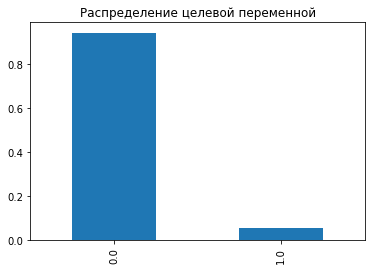

In [12]:
(y.value_counts()/y.shape[0]).plot(kind='bar', title='Распределение целевой переменной');
y.value_counts()/y.shape

In [13]:
ros = RandomUnderSampler(random_state=42)
x_train, y_train = ros.fit_resample(x_train, y_train)

print("Train")
print(y_train.value_counts()/y_train.shape[0])
print()
print("Test")
print(y_test.value_counts()/y_test.shape[0])

Train
0.0    0.5
1.0    0.5
Name: target, dtype: float64

Test
0.0    0.945209
1.0    0.054791
Name: target, dtype: float64


# Обучение модели

In [16]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame не содержит следующие колонки: %s" % cols_error)

In [26]:
f_prep_pipeline = make_pipeline(
    ColumnSelector(columns=f_ok),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            ColumnSelector(f_numeric),
            SimpleImputer(strategy="median"), # Заполнение пропусков.
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            ColumnSelector(f_categorical),
            SimpleImputer(strategy="most_frequent"),
            OneHotEncoder(handle_unknown='ignore')
        )),
        ("boolean_features", make_pipeline(
            ColumnSelector(f_binary),
        ))
    ])
)

In [64]:
xgb_model = xgb.XGBClassifier(#silent=True,
                                    random_state=21,
                                    # class_weights=[1, disbalance],
                                    learning_rate =0.1,
                                    n_estimators=1000,
                                     max_depth=4,
                                     min_child_weight=6,
                                     gamma=0,
                                     subsample=0.8,
                                     colsample_bytree=0.8,
                                     reg_alpha=0.005,
                                     objective= 'binary:logistic',
                                     nthread=4,
                                     scale_pos_weight=1,
                                     seed=27)

In [65]:
xgb_boost_pipe = make_pipeline(
    f_prep_pipeline,
    # TruncatedSVD(n_components=150, n_iter=7, random_state=42),# PCA(n_components=20, whiten=True),
    xgb_model
)

In [66]:
X_train_transformed = xgb_boost_pipe[:-1].fit_transform(x_train)
x_test_transformed = xgb_boost_pipe[:-1].transform(x_test)

In [67]:
%%time
xgb_boost_pipe[-1].fit(
       X=X_train_transformed,
       y=y_train,
       eval_set=[(x_test_transformed, y_test)],
     )

[0]	validation_0-logloss:0.68542
[1]	validation_0-logloss:0.63129
[2]	validation_0-logloss:0.62584
[3]	validation_0-logloss:0.58303
[4]	validation_0-logloss:0.54739
[5]	validation_0-logloss:0.51800
[6]	validation_0-logloss:0.51503
[7]	validation_0-logloss:0.49054
[8]	validation_0-logloss:0.46996
[9]	validation_0-logloss:0.45272
[10]	validation_0-logloss:0.43789
[11]	validation_0-logloss:0.42554
[12]	validation_0-logloss:0.41506
[13]	validation_0-logloss:0.41428
[14]	validation_0-logloss:0.41343
[15]	validation_0-logloss:0.40456
[16]	validation_0-logloss:0.40426
[17]	validation_0-logloss:0.39670
[18]	validation_0-logloss:0.39041
[19]	validation_0-logloss:0.38511
[20]	validation_0-logloss:0.38060
[21]	validation_0-logloss:0.37695
[22]	validation_0-logloss:0.37393
[23]	validation_0-logloss:0.37142
[24]	validation_0-logloss:0.36930
[25]	validation_0-logloss:0.36896
[26]	validation_0-logloss:0.36720
[27]	validation_0-logloss:0.36549
[28]	validation_0-logloss:0.36499
[29]	validation_0-loglos

[238]	validation_0-logloss:0.35676
[239]	validation_0-logloss:0.35690
[240]	validation_0-logloss:0.35700
[241]	validation_0-logloss:0.35704
[242]	validation_0-logloss:0.35718
[243]	validation_0-logloss:0.35728
[244]	validation_0-logloss:0.35732
[245]	validation_0-logloss:0.35741
[246]	validation_0-logloss:0.35711
[247]	validation_0-logloss:0.35713
[248]	validation_0-logloss:0.35687
[249]	validation_0-logloss:0.35702
[250]	validation_0-logloss:0.35691
[251]	validation_0-logloss:0.35702
[252]	validation_0-logloss:0.35706
[253]	validation_0-logloss:0.35714
[254]	validation_0-logloss:0.35720
[255]	validation_0-logloss:0.35713
[256]	validation_0-logloss:0.35693
[257]	validation_0-logloss:0.35713
[258]	validation_0-logloss:0.35715
[259]	validation_0-logloss:0.35728
[260]	validation_0-logloss:0.35728
[261]	validation_0-logloss:0.35726
[262]	validation_0-logloss:0.35733
[263]	validation_0-logloss:0.35747
[264]	validation_0-logloss:0.35750
[265]	validation_0-logloss:0.35762
[266]	validation_0-l

[473]	validation_0-logloss:0.35989
[474]	validation_0-logloss:0.35990
[475]	validation_0-logloss:0.35997
[476]	validation_0-logloss:0.35983
[477]	validation_0-logloss:0.35993
[478]	validation_0-logloss:0.35984
[479]	validation_0-logloss:0.35983
[480]	validation_0-logloss:0.35976
[481]	validation_0-logloss:0.35991
[482]	validation_0-logloss:0.36001
[483]	validation_0-logloss:0.36009
[484]	validation_0-logloss:0.36000
[485]	validation_0-logloss:0.35992
[486]	validation_0-logloss:0.35996
[487]	validation_0-logloss:0.36013
[488]	validation_0-logloss:0.36010
[489]	validation_0-logloss:0.36006
[490]	validation_0-logloss:0.36024
[491]	validation_0-logloss:0.36027
[492]	validation_0-logloss:0.36025
[493]	validation_0-logloss:0.36024
[494]	validation_0-logloss:0.36035
[495]	validation_0-logloss:0.36052
[496]	validation_0-logloss:0.36046
[497]	validation_0-logloss:0.36033
[498]	validation_0-logloss:0.36034
[499]	validation_0-logloss:0.36029
[500]	validation_0-logloss:0.36018
[501]	validation_0-l

[708]	validation_0-logloss:0.36272
[709]	validation_0-logloss:0.36266
[710]	validation_0-logloss:0.36269
[711]	validation_0-logloss:0.36270
[712]	validation_0-logloss:0.36261
[713]	validation_0-logloss:0.36272
[714]	validation_0-logloss:0.36265
[715]	validation_0-logloss:0.36285
[716]	validation_0-logloss:0.36306
[717]	validation_0-logloss:0.36302
[718]	validation_0-logloss:0.36327
[719]	validation_0-logloss:0.36351
[720]	validation_0-logloss:0.36332
[721]	validation_0-logloss:0.36309
[722]	validation_0-logloss:0.36326
[723]	validation_0-logloss:0.36308
[724]	validation_0-logloss:0.36298
[725]	validation_0-logloss:0.36306
[726]	validation_0-logloss:0.36313
[727]	validation_0-logloss:0.36305
[728]	validation_0-logloss:0.36292
[729]	validation_0-logloss:0.36291
[730]	validation_0-logloss:0.36281
[731]	validation_0-logloss:0.36273
[732]	validation_0-logloss:0.36271
[733]	validation_0-logloss:0.36274
[734]	validation_0-logloss:0.36278
[735]	validation_0-logloss:0.36298
[736]	validation_0-l

[943]	validation_0-logloss:0.36667
[944]	validation_0-logloss:0.36660
[945]	validation_0-logloss:0.36668
[946]	validation_0-logloss:0.36667
[947]	validation_0-logloss:0.36646
[948]	validation_0-logloss:0.36641
[949]	validation_0-logloss:0.36654
[950]	validation_0-logloss:0.36657
[951]	validation_0-logloss:0.36643
[952]	validation_0-logloss:0.36622
[953]	validation_0-logloss:0.36625
[954]	validation_0-logloss:0.36623
[955]	validation_0-logloss:0.36620
[956]	validation_0-logloss:0.36618
[957]	validation_0-logloss:0.36634
[958]	validation_0-logloss:0.36643
[959]	validation_0-logloss:0.36636
[960]	validation_0-logloss:0.36641
[961]	validation_0-logloss:0.36647
[962]	validation_0-logloss:0.36673
[963]	validation_0-logloss:0.36672
[964]	validation_0-logloss:0.36663
[965]	validation_0-logloss:0.36651
[966]	validation_0-logloss:0.36644
[967]	validation_0-logloss:0.36632
[968]	validation_0-logloss:0.36600
[969]	validation_0-logloss:0.36622
[970]	validation_0-logloss:0.36601
[971]	validation_0-l

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=6,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=4, nthread=4, num_parallel_tree=1, predictor='auto',
              random_state=21, reg_alpha=0.005, ...)

##### Времени на обучение затрачено меньше ,чем с помощью catboost.Минимальное значение функции потерь на 382 итерации

# Построение предсказаний на тестовой выборке, оценка качества модели.

In [68]:
test_score = xgb_boost_pipe.predict(x_test)

In [69]:
def plot_confusion_matrix(cm, classes,
                          model_name="",
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest',  cmap=cmap)
    
    plt.grid(False)
    plt.title('%s: confusion matrix' % model_name)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[166695  24412]
 [  1278   9800]]


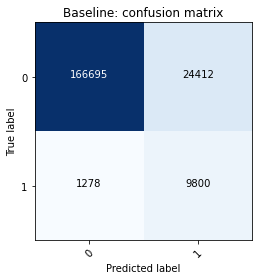

In [70]:
# TN               | FP(Ошибка 2 рода)|
#------------------|------------------|
# FN(Ошибка 1 рода) | TP               |

cm = confusion_matrix(y_test, test_score > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="Baseline")

In [71]:
print(classification_report(y_test, test_score > 0.5))

              precision    recall  f1-score   support

         0.0       0.99      0.87      0.93    191107
         1.0       0.29      0.88      0.43     11078

    accuracy                           0.87    202185
   macro avg       0.64      0.88      0.68    202185
weighted avg       0.95      0.87      0.90    202185



##### Значение метрик почти одинаково,но модель XGBoost обучается быстрее

In [72]:
fpr, tpr, roc_thresholds = roc_curve(y_test, test_score)
precision, recall, pr_thresholds = precision_recall_curve(y_test, test_score)

Baseline: AUC_ROC = 0.878


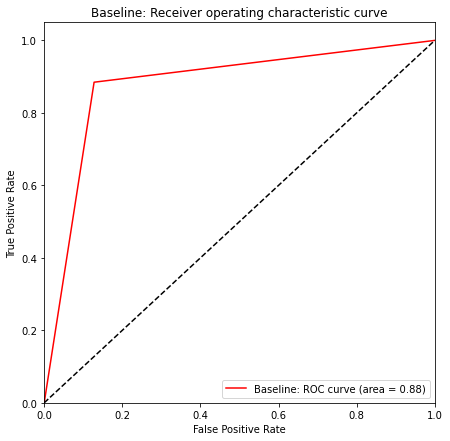

In [73]:
def plot_roc_curve(fpr, tpr, model_name="", color=None):
    plt.plot(fpr, tpr, label='%s: ROC curve (area = %0.2f)' %
             (model_name, auc(fpr, tpr)), color=color)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s: Receiver operating characteristic curve' % model_name)
    plt.legend(loc="lower right")

plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "Baseline", color='r')
print("Baseline: AUC_ROC = %.3f" % auc(fpr, tpr))

##### Площадь под кривой на 0.001 меньше,чем в модели catboost

Baseline: AUC_PR = 0.589


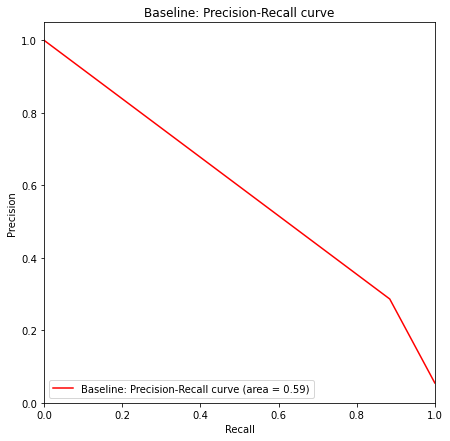

In [74]:
def plot_precision_recall_curve(recall, precision, model_name="", color=None):
    plt.plot(recall, precision, label='%s: Precision-Recall curve (area = %0.2f)' %
             (model_name, auc(recall, precision)), color=color)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("%s: Precision-Recall curve" % model_name)
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.legend(loc="lower left")

plt.figure(figsize=(7, 7))
    
plot_precision_recall_curve(recall, precision, "Baseline", color='r')
print("Baseline: AUC_PR = %.3f" % auc(recall, precision))

# Запись обучающей выборки в файл

In [75]:
with open('xgbboost_model.pickle', 'wb') as f:
    pickle.dump(xgb_boost_pipe, f, protocol=pickle.HIGHEST_PROTOCOL)

# Финальное предсказание

In [76]:
with open('xgbboost_model.pickle', 'rb') as f:
    xgb_boost_pipe =  pickle.load(f)

In [77]:
data_test  = pd.read_csv(DATA_TEST_FEATURES_PATH)

In [78]:
data_test.loc[(data_test['252'] > 1, '252')] = 2.0

In [80]:
y_result_pred = xgb_boost_pipe.predict(data_test) 
y_result_pred

array([0, 0, 1, ..., 0, 1, 0])

In [81]:
x_test = pd.read_csv(users_data_df_PATH)
x_test = x_test.drop('Unnamed: 0', axis=1)

In [82]:
x_test['target'] = y_result_pred

In [83]:
x_test.to_csv(ANSWER_TEST_PATH, index=False)

In [84]:
x_test.head()

,id,vas_id,buy_time,target
0,3130519,2.0,1548018000,0
1,2000860,4.0,1548018000,0
2,1099444,2.0,1546808400,1
3,1343255,5.0,1547413200,1
4,1277040,2.0,1546808400,1


In [85]:
x_test.tail()

,id,vas_id,buy_time,target
71226,2502453,5.0,1548018000,1
71227,1693213,2.0,1548018000,0
71228,1891350,2.0,1548018000,0
71229,2437172,2.0,1548018000,1
71230,988236,2.0,1548018000,0


##### Предсказания скорее всего совпали